<a href="https://colab.research.google.com/github/eunzzae/Study_DS/blob/main/27)_%EA%B0%80%EB%AD%84%EC%88%98%EC%A4%80_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 가뭄수준 예측
>**목차**

* 문제상황 및 데이터 살펴보기  
* 무제해결 프로세스 정의  
1) 가뭄수준별 데이터 탐색  
2) 가뭄 심각 지역 탐색  
3) 가뭄 추이 파악을 통한 대책안 수립  

In [1]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# # ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
# import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/part3_lecture_fastcampus/chapter26')
# # '/content/drive/MyDrive/Colab Notebooks/ ← 여기 경로까지는 본인의 경로 입력, part3_lecture_fastcampus/chapter26' ← 변경X
# os.getcwd()

Mounted at /content/drive


## 문제상황 및 데이터 살펴보기  
---
>**시나리오**  

```
최근 들어 가뭄(건조)로 인하여 지역 피해건수가 증가하고 있다. 정부에 제한된 자원을 가지고 효율적으로 건조 지역 피해 복구를  
진행해야하는 상황이다. 이에 가뭄이 심각한 지역을 우선 탐색하고 우선순위에 따라서 복구를 진행하고자 한다.

```  

> **데이터 살펴보기**

* 가뭄 수준 측정 데이터
* 데이터 명세 ⬇

|map_date|state_abb|valid_start|valid_end|stat_fmt|drought_lvl|
|:---:|:---:|:---:|:---:|:---:|:---:|
|측정일자|주|측정일자|측정종료일자|통계fmt|가뭄수준|
|area_pct|area_total|pop_pct|pop_total|
|지역 수분량 비율|지역 수분 전체량|물 저장 비율|물 저장 총량|

In [2]:
# Data read
import pandas as pd
bath = '/content/drive/MyDrive/[STUDY] 데이터사이언스/데이터분석/data/chapter27_가뭄수준 예측/'
df = pd.read_csv(bath + 'chapter27_drought.csv')
df.head()

,map_date,state_abb,valid_start,valid_end,stat_fmt,drought_lvl,area_pct,area_total,pop_pct,pop_total
0,20210713,AK,2021-07-13,2021-07-19,1,NaN,74.35,433133.18,33.91,240644.16
1,20210713,AK,2021-07-13,2021-07-19,1,D0,25.65,149435.11,66.09,468985.84
2,20210713,AK,2021-07-13,2021-07-19,1,D1,0.00,0.00,0.00,0.00
3,20210713,AK,2021-07-13,2021-07-19,1,D2,0.00,0.00,0.00,0.00
4,20210713,AK,2021-07-13,2021-07-19,1,D3,0.00,0.00,0.00,0.00



## **문제해결 프로세스 정의**
---
> **문제정의**

```
가뭄 심각으로 인해 우선 복구 지역 불분명
```  

> **기대효과**

```
가뭄 심각 지역 탐색 및 우선 복구 지역 선정 및 복구 시작
```

> **해결방안**

```
가뭄 복구 우선 복구 지역 선정 및 가용 자원이용 복구 수행
Session 1
 - Data 전처리 및 가뭄 데이터 EDA
Session 2
 - 지역별 가뭄 수준 확인 및 월 별 가뭄 추이 분석
Session 3
 - 전략 수립 및 우선 복구 지역 선정
```



> **성과측정**  

```
지역 복구율 및 가뭄 수준 경보 하향
```

> **현업적용**  

```
가뭄 심각 지역 탐색 및 우선 복구를 통한 재해 대처
```

> **주요 코드 미리 살펴보기**  

```
session 1 → pivot_table()
session 2 → sns.barplot
session 3 → isin()
```




## Session 1  
## 가뭄수준별 데이터 탐색

### Data 전처리
---

In [3]:
# Data shape
# 325,728 row, 10cols
print('df', df.shape)

df (325728, 10)


In [4]:
# Data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325728 entries, 0 to 325727
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   map_date     325728 non-null  int64  
 1   state_abb    325728 non-null  object 
 2   valid_start  325728 non-null  object 
 3   valid_end    325728 non-null  object 
 4   stat_fmt     325728 non-null  int64  
 5   drought_lvl  271440 non-null  object 
 6   area_pct     325728 non-null  float64
 7   area_total   322513 non-null  float64
 8   pop_pct      325728 non-null  float64
 9   pop_total    322116 non-null  float64
dtypes: float64(4), int64(2), object(4)
memory usage: 24.9+ MB


In [5]:
# null 확인
df.isnull().sum()

map_date           0
state_abb          0
valid_start        0
valid_end          0
stat_fmt           0
drought_lvl    54288
area_pct           0
area_total      3215
pop_pct            0
pop_total       3612
dtype: int64

In [6]:
import pandas as pd

df['drought_lvl'].fillna('None', inplace=True)

In [7]:
df.isnull().sum()

map_date          0
state_abb         0
valid_start       0
valid_end         0
stat_fmt          0
drought_lvl       0
area_pct          0
area_total     3215
pop_pct           0
pop_total      3612
dtype: int64

In [8]:
# Outlier 확인
df.describe()

,map_date,stat_fmt,area_pct,area_total,pop_pct,pop_total
count,3.257280e+05,325728.0,325728.000000,322513.000000,325728.000000,3.221160e+05
mean,2.011103e+07,1.0,22.975505,17008.394861,22.418064,1.387939e+06
std,5.787383e+04,0.0,35.153066,41068.300091,35.929533,3.764989e+06
min,2.001072e+07,1.0,0.000000,0.000000,0.000000,0.000000e+00
25%,2.006072e+07,1.0,0.000000,0.000000,0.000000,0.000000e+00
50%,2.011072e+07,1.0,0.000000,0.000000,0.000000,0.000000e+00
75%,2.016071e+07,1.0,39.640000,17557.420000,34.380000,8.979340e+05
max,2.021071e+07,1.0,100.000000,582568.290000,101.800000,3.725396e+07


In [9]:
# 지역별 한 주 단위 Data가 row 기준으로 쌓여있으며, 가뭄레벨 None-D4까지 적재되어있음.
# 현 수준으로는 활용하기 어려운 데이터
df.head(15)

,map_date,state_abb,valid_start,valid_end,stat_fmt,drought_lvl,area_pct,area_total,pop_pct,pop_total
0,20210713,AK,2021-07-13,2021-07-19,1,None,74.35,433133.18,33.91,240644.16
1,20210713,AK,2021-07-13,2021-07-19,1,D0,25.65,149435.11,66.09,468985.84
2,20210713,AK,2021-07-13,2021-07-19,1,D1,0.00,0.00,0.00,0.00
3,20210713,AK,2021-07-13,2021-07-19,1,D2,0.00,0.00,0.00,0.00
4,20210713,AK,2021-07-13,2021-07-19,1,D3,0.00,0.00,0.00,0.00
5,20210713,AK,2021-07-13,2021-07-19,1,D4,0.00,0.00,0.00,0.00
6,20210706,AK,2021-07-06,2021-07-12,1,None,74.35,433133.18,33.91,240644.16
7,20210706,AK,2021-07-06,2021-07-12,1,D0,25.65,149435.11,66.09,468985.84
8,20210706,AK,2021-07-06,2021-07-12,1,D1,0.00,0.00,0.00,0.00
9,20210706,AK,2021-07-06,2021-07-12,1,D2,0.00,0.00,0.00,0.00


In [10]:
df.columns

Index(['map_date', 'state_abb', 'valid_start', 'valid_end', 'stat_fmt',
       'drought_lvl', 'area_pct', 'area_total', 'pop_pct', 'pop_total'],
      dtype='object')

In [11]:
# 지역과 날짜 기준으로 unique한 row로 변환
df = df.pivot_table(index=['map_date', 'state_abb', 'valid_start', 'valid_end', 'stat_fmt'], columns='drought_lvl', values=['area_pct', 'area_total', 'pop_pct', 'pop_total'])
df = pd.DataFrame(df).reset_index()

In [12]:
df.head()

map_date state_abb valid_start   valid_end stat_fmt area_pct  \
drought_lvl                                                            D0   
0            20010717        AK  2001-07-17  2001-07-23        1     2.08   
1            20010717        AL  2001-07-17  2001-07-23        1     0.01   
2            20010717        AR  2001-07-17  2001-07-23        1    50.95   
3            20010717        AZ  2001-07-17  2001-07-23        1     0.00   
4            20010717        CA  2001-07-17  2001-07-23        1    44.06   

                                      ... pop_pct                     \
drought_lvl     D1     D2    D3   D4  ...      D2    D3   D4    None   
0             0.00   0.00  0.00  0.0  ...    0.00  0.00  0.0   92.71   
1             0.00   0.00  0.00  0.0  ...    0.00  0.00  0.0  100.00   
2            18.05   5.84  0.00  0.0  ...    6.95  0.00  0.0   44.64   
3             0.00   0.00  0.00  0.0  ...    0.00  0.00  0.0  100.00   
4            27.19  19.79  9.69  0.0  ...    1.92  0.56  0.0   74.66   

              pop_total                                                      
drought_lvl          D0          D1         D2         D3   D4         None  
0              51730.64        0.00       0.00       0.00  0.0    657899.35  
1                156.30        0.00       0.00       0.00  0.0   4779579.72  
2            1614202.92   442080.04  202591.07       0.00  0.0   1301715.06  
3                  0.00        0.00       0.00       0.00  0.0   6392017.00  
4            9440307.02  1296768.92  713824.68  208064.43  0.0  27813649.39  

[5 rows x 29 columns]

In [13]:
# multi index는 각 col당 name을 부여하면, 하나의 col로 설정됨.
df.columns=['map_date', 'state_abb', 'valid_start', 'valid_end', 'stat_fmt',
       'D0_area_pct', 'D1_area_pct', 'D2_area_pct', 'D3_area_pct', 'D4_area_pct', 'None_area_pct',
       'D0_area_total', 'D1_area_total', 'D2_area_total', 'D3_area_total', 'D4_area_total', 'None_area_total',
       'D0_pop_pct', 'D1_pop_pct', 'D2_pop_pct', 'D3_pop_pct', 'D4_pop_pct', 'None_pop_pct',
       'D0_pop_total', 'D1_pop_total', 'D2_pop_total', 'D3_pop_total', 'D4_pop_total', 'None_pop_total']

In [14]:
pd.set_option('display.max_columns', 500)
df.head()

,map_date,state_abb,valid_start,valid_end,stat_fmt,D0_area_pct,D1_area_pct,D2_area_pct,D3_area_pct,D4_area_pct,None_area_pct,D0_area_total,D1_area_total,D2_area_total,D3_area_total,D4_area_total,None_area_total,D0_pop_pct,D1_pop_pct,D2_pop_pct,D3_pop_pct,D4_pop_pct,None_pop_pct,D0_pop_total,D1_pop_total,D2_pop_total,D3_pop_total,D4_pop_total,None_pop_total
0,20010717,AK,2001-07-17,2001-07-23,1,2.08,0.00,0.00,0.00,0.0,97.92,12091.73,0.00,0.00,0.00,0.0,570476.56,7.29,0.00,0.00,0.00,0.0,92.71,51730.64,0.00,0.00,0.00,0.0,657899.35
1,20010717,AL,2001-07-17,2001-07-23,1,0.01,0.00,0.00,0.00,0.0,99.99,3.32,0.00,0.00,0.00,0.0,51601.03,0.00,0.00,0.00,0.00,0.0,100.00,156.30,0.00,0.00,0.00,0.0,4779579.72
2,20010717,AR,2001-07-17,2001-07-23,1,50.95,18.05,5.84,0.00,0.0,49.05,27087.20,9593.26,3102.19,0.00,0.0,26075.56,55.36,15.16,6.95,0.00,0.0,44.64,1614202.92,442080.04,202591.07,0.00,0.0,1301715.06
3,20010717,AZ,2001-07-17,2001-07-23,1,0.00,0.00,0.00,0.00,0.0,100.00,0.00,0.00,0.00,0.00,0.0,114034.82,0.00,0.00,0.00,0.00,0.0,100.00,0.00,0.00,0.00,0.00,0.0,6392017.00
4,20010717,CA,2001-07-17,2001-07-23,1,44.06,27.19,19.79,9.69,0.0,55.94,69676.70,43005.24,31291.14,15322.64,0.0,88471.17,25.34,3.48,1.92,0.56,0.0,74.66,9440307.02,1296768.92,713824.68,208064.43,0.0,27813649.39


In [15]:
# 순서정렬
df=df[['map_date', 'state_abb', 'valid_start', 'valid_end', 'stat_fmt',
        'None_area_pct', 'D0_area_pct', 'D1_area_pct', 'D2_area_pct', 'D3_area_pct', 'D4_area_pct',
       'None_pop_pct', 'D0_pop_pct', 'D1_pop_pct', 'D2_pop_pct', 'D3_pop_pct', 'D4_pop_pct',
       'None_area_total','D0_area_total', 'D1_area_total', 'D2_area_total', 'D3_area_total', 'D4_area_total',
       'None_pop_total','D0_pop_total', 'D1_pop_total', 'D2_pop_total', 'D3_pop_total', 'D4_pop_total']]
df.head()

,map_date,state_abb,valid_start,valid_end,stat_fmt,None_area_pct,D0_area_pct,D1_area_pct,D2_area_pct,D3_area_pct,D4_area_pct,None_pop_pct,D0_pop_pct,D1_pop_pct,D2_pop_pct,D3_pop_pct,D4_pop_pct,None_area_total,D0_area_total,D1_area_total,D2_area_total,D3_area_total,D4_area_total,None_pop_total,D0_pop_total,D1_pop_total,D2_pop_total,D3_pop_total,D4_pop_total
0,20010717,AK,2001-07-17,2001-07-23,1,97.92,2.08,0.00,0.00,0.00,0.0,92.71,7.29,0.00,0.00,0.00,0.0,570476.56,12091.73,0.00,0.00,0.00,0.0,657899.35,51730.64,0.00,0.00,0.00,0.0
1,20010717,AL,2001-07-17,2001-07-23,1,99.99,0.01,0.00,0.00,0.00,0.0,100.00,0.00,0.00,0.00,0.00,0.0,51601.03,3.32,0.00,0.00,0.00,0.0,4779579.72,156.30,0.00,0.00,0.00,0.0
2,20010717,AR,2001-07-17,2001-07-23,1,49.05,50.95,18.05,5.84,0.00,0.0,44.64,55.36,15.16,6.95,0.00,0.0,26075.56,27087.20,9593.26,3102.19,0.00,0.0,1301715.06,1614202.92,442080.04,202591.07,0.00,0.0
3,20010717,AZ,2001-07-17,2001-07-23,1,100.00,0.00,0.00,0.00,0.00,0.0,100.00,0.00,0.00,0.00,0.00,0.0,114034.82,0.00,0.00,0.00,0.00,0.0,6392017.00,0.00,0.00,0.00,0.00,0.0
4,20010717,CA,2001-07-17,2001-07-23,1,55.94,44.06,27.19,19.79,9.69,0.0,74.66,25.34,3.48,1.92,0.56,0.0,88471.17,69676.70,43005.24,31291.14,15322.64,0.0,27813649.39,9440307.02,1296768.92,713824.68,208064.43,0.0


In [16]:
# null 확인
df.isnull().sum()

map_date              0
state_abb             0
valid_start           0
valid_end             0
stat_fmt              0
None_area_pct         0
D0_area_pct           0
D1_area_pct           0
D2_area_pct           0
D3_area_pct           0
D4_area_pct           0
None_pop_pct          0
D0_pop_pct            0
D1_pop_pct            0
D2_pop_pct            0
D3_pop_pct            0
D4_pop_pct            0
None_area_total       0
D0_area_total         0
D1_area_total         0
D2_area_total         0
D3_area_total         0
D4_area_total      3215
None_pop_total        0
D0_pop_total          0
D1_pop_total          0
D2_pop_total          0
D3_pop_total          0
D4_pop_total       3612
dtype: int64

In [17]:
df.fillna(0, inplace=True)

In [18]:
df.head()

,map_date,state_abb,valid_start,valid_end,stat_fmt,None_area_pct,D0_area_pct,D1_area_pct,D2_area_pct,D3_area_pct,D4_area_pct,None_pop_pct,D0_pop_pct,D1_pop_pct,D2_pop_pct,D3_pop_pct,D4_pop_pct,None_area_total,D0_area_total,D1_area_total,D2_area_total,D3_area_total,D4_area_total,None_pop_total,D0_pop_total,D1_pop_total,D2_pop_total,D3_pop_total,D4_pop_total
0,20010717,AK,2001-07-17,2001-07-23,1,97.92,2.08,0.00,0.00,0.00,0.0,92.71,7.29,0.00,0.00,0.00,0.0,570476.56,12091.73,0.00,0.00,0.00,0.0,657899.35,51730.64,0.00,0.00,0.00,0.0
1,20010717,AL,2001-07-17,2001-07-23,1,99.99,0.01,0.00,0.00,0.00,0.0,100.00,0.00,0.00,0.00,0.00,0.0,51601.03,3.32,0.00,0.00,0.00,0.0,4779579.72,156.30,0.00,0.00,0.00,0.0
2,20010717,AR,2001-07-17,2001-07-23,1,49.05,50.95,18.05,5.84,0.00,0.0,44.64,55.36,15.16,6.95,0.00,0.0,26075.56,27087.20,9593.26,3102.19,0.00,0.0,1301715.06,1614202.92,442080.04,202591.07,0.00,0.0
3,20010717,AZ,2001-07-17,2001-07-23,1,100.00,0.00,0.00,0.00,0.00,0.0,100.00,0.00,0.00,0.00,0.00,0.0,114034.82,0.00,0.00,0.00,0.00,0.0,6392017.00,0.00,0.00,0.00,0.00,0.0
4,20010717,CA,2001-07-17,2001-07-23,1,55.94,44.06,27.19,19.79,9.69,0.0,74.66,25.34,3.48,1.92,0.56,0.0,88471.17,69676.70,43005.24,31291.14,15322.64,0.0,27813649.39,9440307.02,1296768.92,713824.68,208064.43,0.0


### 가뭄수준 확인
---

In [19]:
# 총 몇개의 지역이 있는지 확인
# 52개
df['state_abb'].nunique()

52

In [20]:
# 지역별 1,044 week 동안 가뭄 History data
df['state_abb'].value_counts().head(10)

state_abb
AK    1044
AL    1044
ND    1044
NE    1044
NH    1044
NJ    1044
NM    1044
NV    1044
NY    1044
OH    1044
Name: count, dtype: int64

In [21]:
# 지역별 1,044 week 동안 가뭄 History data
df[df['state_abb']=='AK'].sort_values('map_date')

,map_date,state_abb,valid_start,valid_end,stat_fmt,None_area_pct,D0_area_pct,D1_area_pct,D2_area_pct,D3_area_pct,D4_area_pct,None_pop_pct,D0_pop_pct,D1_pop_pct,D2_pop_pct,D3_pop_pct,D4_pop_pct,None_area_total,D0_area_total,D1_area_total,D2_area_total,D3_area_total,D4_area_total,None_pop_total,D0_pop_total,D1_pop_total,D2_pop_total,D3_pop_total,D4_pop_total
0,20010717,AK,2001-07-17,2001-07-23,1,97.92,2.08,0.0,0.0,0.0,0.0,92.71,7.29,0.0,0.0,0.0,0.0,570476.56,12091.73,0.0,0.0,0.0,0.0,657899.35,51730.64,0.0,0.0,0.0,0.0
52,20010724,AK,2001-07-24,2001-07-30,1,97.92,2.08,0.0,0.0,0.0,0.0,92.71,7.29,0.0,0.0,0.0,0.0,570476.56,12091.73,0.0,0.0,0.0,0.0,657899.35,51730.64,0.0,0.0,0.0,0.0
104,20010731,AK,2001-07-31,2001-08-06,1,100.00,0.00,0.0,0.0,0.0,0.0,100.00,0.00,0.0,0.0,0.0,0.0,582568.29,0.00,0.0,0.0,0.0,0.0,709629.99,0.00,0.0,0.0,0.0,0.0
156,20010807,AK,2001-08-07,2001-08-13,1,100.00,0.00,0.0,0.0,0.0,0.0,100.00,0.00,0.0,0.0,0.0,0.0,582568.29,0.00,0.0,0.0,0.0,0.0,709629.99,0.00,0.0,0.0,0.0,0.0
208,20010814,AK,2001-08-14,2001-08-20,1,100.00,0.00,0.0,0.0,0.0,0.0,100.00,0.00,0.0,0.0,0.0,0.0,582568.29,0.00,0.0,0.0,0.0,0.0,709629.99,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54028,20210615,AK,2021-06-15,2021-06-21,1,85.92,14.08,0.0,0.0,0.0,0.0,98.96,1.04,0.0,0.0,0.0,0.0,500539.66,82028.63,0.0,0.0,0.0,0.0,702217.65,7412.34,0.0,0.0,0.0,0.0
54080,20210622,AK,2021-06-22,2021-06-28,1,85.92,14.08,0.0,0.0,0.0,0.0,98.96,1.04,0.0,0.0,0.0,0.0,500539.66,82028.63,0.0,0.0,0.0,0.0,702217.65,7412.34,0.0,0.0,0.0,0.0
54132,20210629,AK,2021-06-29,2021-07-05,1,85.92,14.08,0.0,0.0,0.0,0.0,98.96,1.04,0.0,0.0,0.0,0.0,500539.66,82028.63,0.0,0.0,0.0,0.0,702217.65,7412.34,0.0,0.0,0.0,0.0
54184,20210706,AK,2021-07-06,2021-07-12,1,74.35,25.65,0.0,0.0,0.0,0.0,33.91,66.09,0.0,0.0,0.0,0.0,433133.18,149435.11,0.0,0.0,0.0,0.0,240644.16,468985.84,0.0,0.0,0.0,0.0


In [22]:
# 2001년 07월부터 2021년 07월까지의 데이터
df['map_date'].min(), df['map_date'].max()

(20010717, 20210713)

## Session 2
## 가뭄 심각 지역 탐색

### 가뭄 레벨 부여
---

In [23]:
# 가뭄 레벨은 None ~ D4까지 있으며, D4인경우 None ~ D3까지의 가뭄수준 데이터가 적재되어 있음
import numpy as np
df['level'] = np.where( (df['None_area_pct'] != 0) & (df['D0_area_pct'] == 0) & (df['D1_area_pct'] == 0) & (df['D2_area_pct'] == 0) & (df['D3_area_pct'] == 0) & (df['D4_area_pct'] == 0), 'None',
                        np.where(   (df['D0_area_pct'] != 0) & (df['D1_area_pct'] == 0) & (df['D2_area_pct'] == 0) & (df['D3_area_pct'] == 0) & (df['D4_area_pct'] == 0), 'D0',
                                 np.where(   (df['D1_area_pct'] != 0) & (df['D2_area_pct'] == 0) & (df['D3_area_pct'] == 0) & (df['D4_area_pct'] == 0), 'D1',
                                          np.where(  (df['D2_area_pct'] != 0) & (df['D3_area_pct'] == 0) & (df['D4_area_pct'] == 0), 'D2',
                                                   np.where(   (df['D3_area_pct'] != 0) & (df['D4_area_pct'] == 0), 'D3', 'D4')))))

### 지역별 가뭄 수준
---

In [24]:
# 지역별 가뭄레벨 도달 횟수 count
df_gp = pd.DataFrame(df.groupby(['state_abb', 'level'], as_index=False)['map_date'].count())
df_gp.head()

,state_abb,level,map_date
0,AK,D0,587
1,AK,D1,146
2,AK,D2,47
3,AK,D3,21
4,AK,None,243


In [25]:
# pivot table 활용 데이터 정제
df_pivot = df_gp.pivot_table(index=['state_abb'], columns='level', values=['map_date'])
df_pivot = pd.DataFrame(df_pivot).reset_index()
df_pivot.fillna(0, inplace=True)
df_pivot.head()

state_abb map_date                                   
level                 D0     D1     D2     D3     D4   None
0            AK    587.0  146.0   47.0   21.0    0.0  243.0
1            AL    217.0  198.0  124.0  150.0   99.0  256.0
2            AR    251.0  224.0  135.0  144.0   52.0  238.0
3            AZ     24.0  152.0  298.0  328.0  218.0   24.0
4            CA    109.0  128.0  341.0  279.0  187.0    0.0

In [26]:
# 순서 정렬
df_pivot.columns = ['state_abb', 'D0', 'D1', 'D2', 'D3', 'D4','None']
df_pivot = df_pivot[['state_abb', 'None', 'D0', 'D1', 'D2', 'D3', 'D4']]
df_pivot.head()

,state_abb,None,D0,D1,D2,D3,D4
0,AK,243.0,587.0,146.0,47.0,21.0,0.0
1,AL,256.0,217.0,198.0,124.0,150.0,99.0
2,AR,238.0,251.0,224.0,135.0,144.0,52.0
3,AZ,24.0,24.0,152.0,298.0,328.0,218.0
4,CA,0.0,109.0,128.0,341.0,279.0,187.0


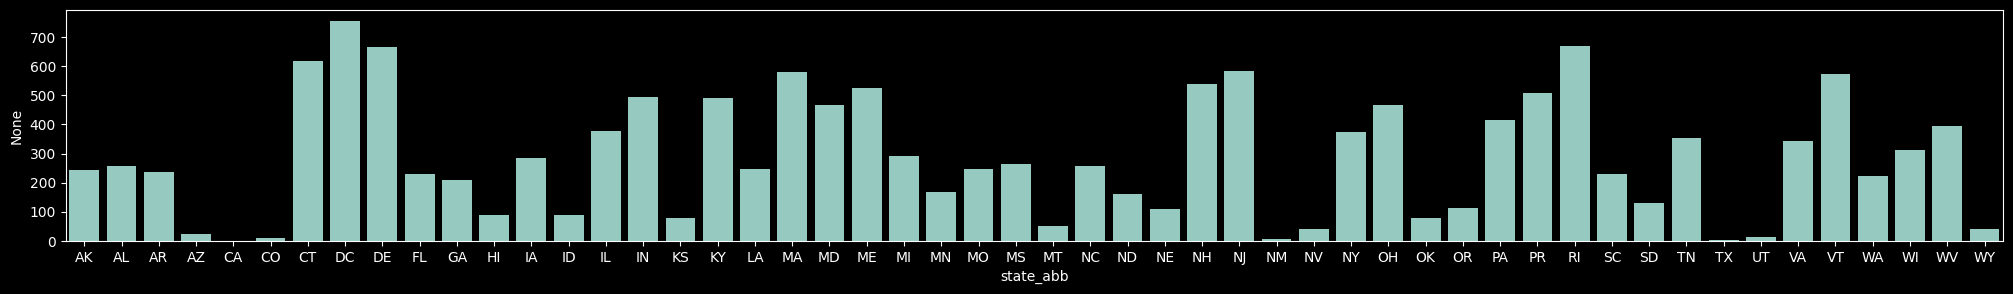

In [27]:
# 지역별 정상 주(week) 수 현황
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

sns.barplot(x="state_abb", y='None', data=df_pivot);
plt.gcf().set_size_inches(25, 3)

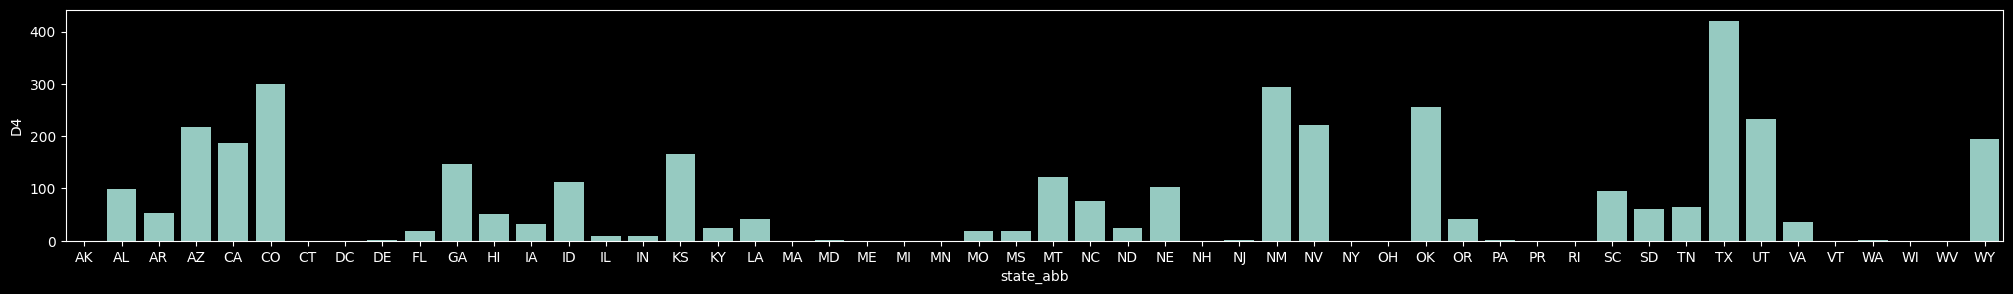

In [28]:
# 지역별 D4 - 심각단계, 주(week) 수 현황
# 정상일수가 많았던 CT, DC, DE 지역의 경우 D4 단계의 count가 적은 것을 확인할 수 있음

sns.barplot(x='state_abb', y='D4', data=df_pivot);
plt.gcf().set_size_inches(25, 3)

### 월 별 가뭄 추이 분석
---
* 추후 장기계획을 위해 월 별 가뭄이 가장 심각한 달은 어디인지 확인 필요

In [29]:
df.head()

,map_date,state_abb,valid_start,valid_end,stat_fmt,None_area_pct,D0_area_pct,D1_area_pct,D2_area_pct,D3_area_pct,D4_area_pct,None_pop_pct,D0_pop_pct,D1_pop_pct,D2_pop_pct,D3_pop_pct,D4_pop_pct,None_area_total,D0_area_total,D1_area_total,D2_area_total,D3_area_total,D4_area_total,None_pop_total,D0_pop_total,D1_pop_total,D2_pop_total,D3_pop_total,D4_pop_total,level
0,20010717,AK,2001-07-17,2001-07-23,1,97.92,2.08,0.00,0.00,0.00,0.0,92.71,7.29,0.00,0.00,0.00,0.0,570476.56,12091.73,0.00,0.00,0.00,0.0,657899.35,51730.64,0.00,0.00,0.00,0.0,D0
1,20010717,AL,2001-07-17,2001-07-23,1,99.99,0.01,0.00,0.00,0.00,0.0,100.00,0.00,0.00,0.00,0.00,0.0,51601.03,3.32,0.00,0.00,0.00,0.0,4779579.72,156.30,0.00,0.00,0.00,0.0,D0
2,20010717,AR,2001-07-17,2001-07-23,1,49.05,50.95,18.05,5.84,0.00,0.0,44.64,55.36,15.16,6.95,0.00,0.0,26075.56,27087.20,9593.26,3102.19,0.00,0.0,1301715.06,1614202.92,442080.04,202591.07,0.00,0.0,D2
3,20010717,AZ,2001-07-17,2001-07-23,1,100.00,0.00,0.00,0.00,0.00,0.0,100.00,0.00,0.00,0.00,0.00,0.0,114034.82,0.00,0.00,0.00,0.00,0.0,6392017.00,0.00,0.00,0.00,0.00,0.0,None
4,20010717,CA,2001-07-17,2001-07-23,1,55.94,44.06,27.19,19.79,9.69,0.0,74.66,25.34,3.48,1.92,0.56,0.0,88471.17,69676.70,43005.24,31291.14,15322.64,0.0,27813649.39,9440307.02,1296768.92,713824.68,208064.43,0.0,D3


In [30]:
# str 활용 년도, 월 col 생성
df['year']= df['map_date'].astype(str).str[:4]
df['month'] = df['map_date'].astype(str).str[4:6]

df[['map_date', 'year', 'month']]

,map_date,year,month
0,20010717,2001,07
1,20010717,2001,07
2,20010717,2001,07
3,20010717,2001,07
4,20010717,2001,07
...,...,...,...
54283,20210713,2021,07
54284,20210713,2021,07
54285,20210713,2021,07
54286,20210713,2021,07


In [31]:
# 심각단계인 D4를 년도, 월별로 count
df_d4 = df[df['level']=='D4'].groupby(['year','month'], as_index = False)['level'].count()
df_d4.head()

,year,month,level
0,2002,04,1
1,2002,05,8
2,2002,06,22
3,2002,07,40
4,2002,08,53


In [32]:
# 최근 5년 data만 가져오기
df_d4_5 = df_d4[df_d4['year'].isin(['2017','2018','2019','2020','2021'])]
df_d4_5['year'].value_counts()

year
2018    10
2020     9
2021     7
2017     5
2019     4
Name: count, dtype: int64

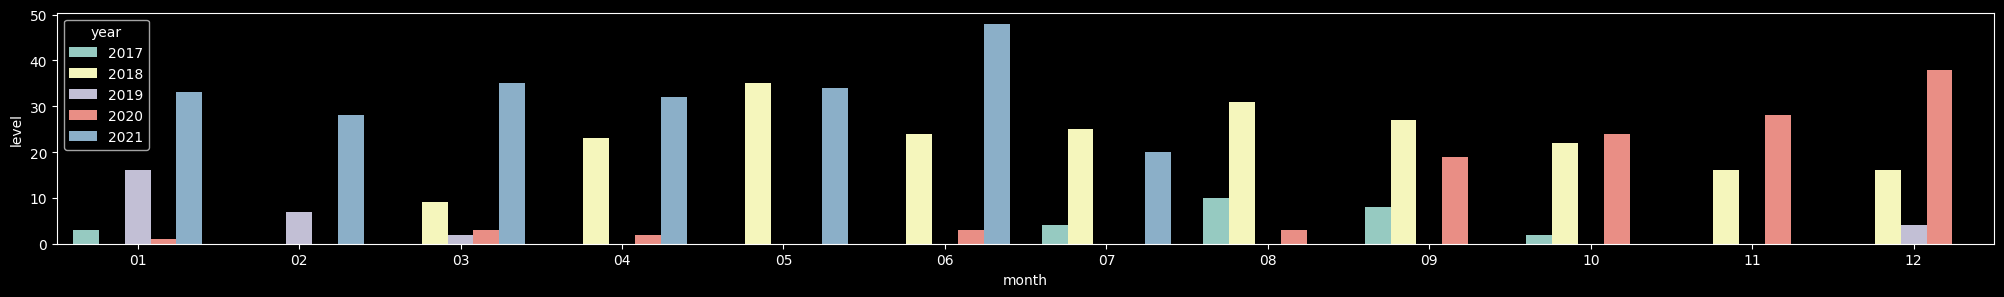

In [33]:
# 최근 5년, 전체기준으로는 양상이 너무 다름
sns.barplot(x='month', y='level', hue='year', data=df_d4_5,
            order=['01','02','03','04','05','06','07','08','09','10','11','12']);
plt.gcf().set_size_inches(25, 3)

In [34]:
df_tx = df[(df['level']=='D4') & (df['state_abb']=='TX')].groupby(['year','month'], as_index=False)['level'].count()
df_tx = df_tx[df_tx['year'].isin(['2017','2018','2019','2020','2021'])]
df_tx.head()

,year,month,level
88,2018,03,1
89,2018,04,4
90,2018,05,5
91,2018,06,3
92,2018,07,1


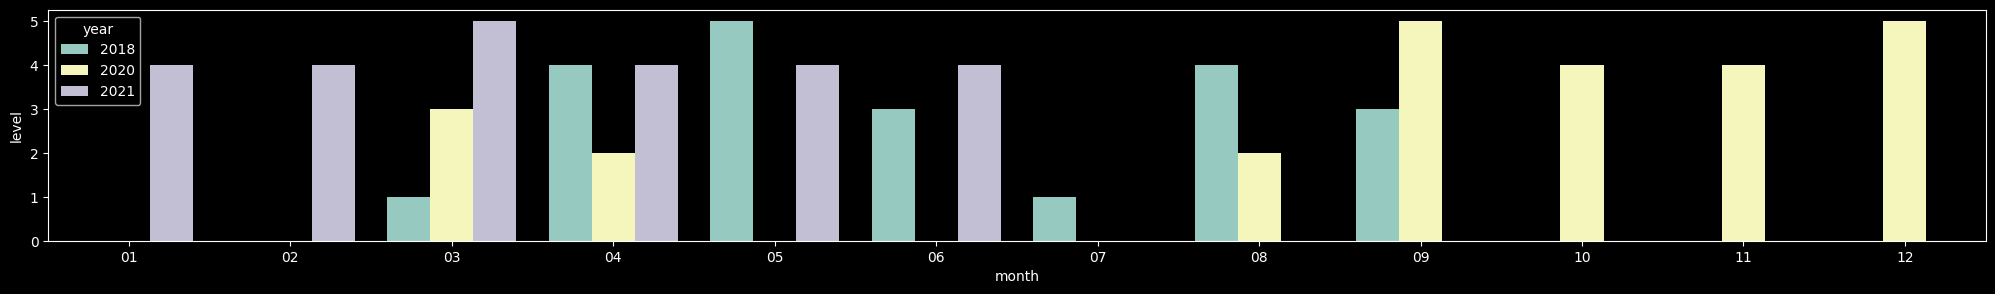

In [35]:
# 최근 5년, 가장 심각 지역 TX(텍사스), 주(State) 단일로 보아도 특별한 경향성 없음
sns.barplot(x='month', y='level', hue='year', data=df_tx,
            order=['01','02','03','04','05','06','07','08','09','10','11','12']);
plt.gcf().set_size_inches(25, 3)

## Session 3
## 가뭄 추이 파악을 통한 대책안 수립

### 심각 단계(D4) 기준 우선순위 선정
---

In [36]:
# D4까지 내려간 횟수가 가장 많은 10개 도시 대상 우선순위 결정
df_pivot.head()

,state_abb,None,D0,D1,D2,D3,D4
0,AK,243.0,587.0,146.0,47.0,21.0,0.0
1,AL,256.0,217.0,198.0,124.0,150.0,99.0
2,AR,238.0,251.0,224.0,135.0,144.0,52.0
3,AZ,24.0,24.0,152.0,298.0,328.0,218.0
4,CA,0.0,109.0,128.0,341.0,279.0,187.0


In [37]:
# D4 횟수 기준으로 내림차순 정렬
df_top10 = df_pivot.sort_values(by=['D4'], ascending=False).head(10)
df_top10['total'] = df_top10['D0'] + df_top10['D1'] + df_top10['D2'] + df_top10['D3'] + df_top10['D4']+df_top10['None']
df_top10

,state_abb,None,D0,D1,D2,D3,D4,total
44,TX,3.0,81.0,144.0,151.0,244.0,421.0,1044.0
5,CO,8.0,119.0,205.0,217.0,195.0,300.0,1044.0
32,NM,5.0,63.0,231.0,210.0,242.0,293.0,1044.0
36,OK,77.0,94.0,180.0,240.0,198.0,255.0,1044.0
45,UT,11.0,86.0,236.0,327.0,151.0,233.0,1044.0
33,NV,39.0,128.0,122.0,243.0,290.0,222.0,1044.0
3,AZ,24.0,24.0,152.0,298.0,328.0,218.0,1044.0
51,WY,40.0,126.0,286.0,184.0,214.0,194.0,1044.0
4,CA,0.0,109.0,128.0,341.0,279.0,187.0,1044.0
16,KS,78.0,134.0,186.0,189.0,292.0,165.0,1044.0


In [38]:
# ratio(정상대비 D4레벨) 기준으로 내림차순 정렬
df_pivot['ratio'] = df_pivot['D4']/df_pivot['None']
df_pivot['ratio'] = np.where(df_pivot['ratio']==np.inf, df_pivot['D4'], df_pivot['ratio'])
df_pivot.head()

,state_abb,None,D0,D1,D2,D3,D4,ratio
0,AK,243.0,587.0,146.0,47.0,21.0,0.0,0.000000
1,AL,256.0,217.0,198.0,124.0,150.0,99.0,0.386719
2,AR,238.0,251.0,224.0,135.0,144.0,52.0,0.218487
3,AZ,24.0,24.0,152.0,298.0,328.0,218.0,9.083333
4,CA,0.0,109.0,128.0,341.0,279.0,187.0,187.000000


In [39]:
df_top10_2 = df_pivot.sort_values(by=['ratio'], ascending=False).head(10)
df_top10_2

,state_abb,None,D0,D1,D2,D3,D4,ratio
4,CA,0.0,109.0,128.0,341.0,279.0,187.0,187.000000
44,TX,3.0,81.0,144.0,151.0,244.0,421.0,140.333333
32,NM,5.0,63.0,231.0,210.0,242.0,293.0,58.600000
5,CO,8.0,119.0,205.0,217.0,195.0,300.0,37.500000
45,UT,11.0,86.0,236.0,327.0,151.0,233.0,21.181818
3,AZ,24.0,24.0,152.0,298.0,328.0,218.0,9.083333
33,NV,39.0,128.0,122.0,243.0,290.0,222.0,5.692308
51,WY,40.0,126.0,286.0,184.0,214.0,194.0,4.850000
36,OK,77.0,94.0,180.0,240.0,198.0,255.0,3.311688
26,MT,50.0,156.0,200.0,200.0,316.0,122.0,2.440000


In [40]:
# count 순위 VS ratio 순위
# 44	TX
# 5	  CO
# 32	NM
# 36	OK
# 45	UT
# 33	NV
# 3	  AZ
# 51	WY
# 4	  CA
# 16	KS

# CA	0.0
# 44	TX
# 32	NM
# 5	  CO
# 45	UT
# 3	  AZ
# 33	NV
# 51	WY
# 36	OK
# 26	MT

### 심각 단계(D4) > 물 저장 비율
---

In [41]:
# D4까지 내려갔을 때 물 저장 비율이 가장 낮은 지역이 자립으로 운영하기 힘든 지역이라고 판단
df.head()

,map_date,state_abb,valid_start,valid_end,stat_fmt,None_area_pct,D0_area_pct,D1_area_pct,D2_area_pct,D3_area_pct,D4_area_pct,None_pop_pct,D0_pop_pct,D1_pop_pct,D2_pop_pct,D3_pop_pct,D4_pop_pct,None_area_total,D0_area_total,D1_area_total,D2_area_total,D3_area_total,D4_area_total,None_pop_total,D0_pop_total,D1_pop_total,D2_pop_total,D3_pop_total,D4_pop_total,level,year,month
0,20010717,AK,2001-07-17,2001-07-23,1,97.92,2.08,0.00,0.00,0.00,0.0,92.71,7.29,0.00,0.00,0.00,0.0,570476.56,12091.73,0.00,0.00,0.00,0.0,657899.35,51730.64,0.00,0.00,0.00,0.0,D0,2001,07
1,20010717,AL,2001-07-17,2001-07-23,1,99.99,0.01,0.00,0.00,0.00,0.0,100.00,0.00,0.00,0.00,0.00,0.0,51601.03,3.32,0.00,0.00,0.00,0.0,4779579.72,156.30,0.00,0.00,0.00,0.0,D0,2001,07
2,20010717,AR,2001-07-17,2001-07-23,1,49.05,50.95,18.05,5.84,0.00,0.0,44.64,55.36,15.16,6.95,0.00,0.0,26075.56,27087.20,9593.26,3102.19,0.00,0.0,1301715.06,1614202.92,442080.04,202591.07,0.00,0.0,D2,2001,07
3,20010717,AZ,2001-07-17,2001-07-23,1,100.00,0.00,0.00,0.00,0.00,0.0,100.00,0.00,0.00,0.00,0.00,0.0,114034.82,0.00,0.00,0.00,0.00,0.0,6392017.00,0.00,0.00,0.00,0.00,0.0,None,2001,07
4,20010717,CA,2001-07-17,2001-07-23,1,55.94,44.06,27.19,19.79,9.69,0.0,74.66,25.34,3.48,1.92,0.56,0.0,88471.17,69676.70,43005.24,31291.14,15322.64,0.0,27813649.39,9440307.02,1296768.92,713824.68,208064.43,0.0,D3,2001,07


In [42]:
# 가뭄 수준이 D4인 데이터만 가져오기
df_d4 = df[df['level']=='D4']
df_d4.head()

,map_date,state_abb,valid_start,valid_end,stat_fmt,None_area_pct,D0_area_pct,D1_area_pct,D2_area_pct,D3_area_pct,D4_area_pct,None_pop_pct,D0_pop_pct,D1_pop_pct,D2_pop_pct,D3_pop_pct,D4_pop_pct,None_area_total,D0_area_total,D1_area_total,D2_area_total,D3_area_total,D4_area_total,None_pop_total,D0_pop_total,D1_pop_total,D2_pop_total,D3_pop_total,D4_pop_total,level,year,month
2158,20020430,MT,2002-04-30,2002-05-06,1,7.34,92.66,88.39,78.04,48.84,5.71,10.29,89.71,76.04,65.35,46.37,2.53,10799.35,136288.97,130012.57,114793.84,71836.82,0.0,101856.30,887558.70,752368.71,646606.23,458794.12,0.0,D4,2002,04
2210,20020507,MT,2002-05-07,2002-05-13,1,7.46,92.54,87.76,78.09,48.30,12.57,10.58,89.42,74.65,65.52,45.78,7.61,10973.64,136114.68,129090.13,114859.04,71043.96,0.0,104664.80,884750.20,738601.10,648287.10,452959.26,0.0,D4,2002,05
2262,20020514,MT,2002-05-14,2002-05-20,1,7.11,92.89,86.06,70.13,44.74,13.23,9.72,90.28,70.85,60.33,45.69,8.93,10457.93,136630.39,126581.35,103151.25,65807.88,0.0,96174.26,893240.74,700956.84,596906.50,452063.23,0.0,D4,2002,05
2314,20020521,MT,2002-05-21,2002-05-27,1,7.21,92.79,79.06,66.71,44.62,12.48,9.82,90.18,66.45,59.41,45.43,7.90,10608.96,136479.36,116281.86,98117.08,65633.34,0.0,97178.81,892236.19,657497.36,587837.34,449514.49,0.0,D4,2002,05
2343,20020528,AZ,2002-05-28,2002-06-03,1,0.00,100.00,100.00,100.00,89.27,19.53,0.00,100.00,100.00,100.00,81.33,2.88,0.00,114034.82,114034.82,114034.82,101798.73,0.0,0.00,6392017.00,6392017.00,6392017.00,5198595.07,0.0,D4,2002,05


In [43]:
# D4단계였을 때 평균 물 저장 비율 데이터 확보
df_d4_pop = pd.DataFrame(df.groupby('state_abb')['D4_pop_pct'].mean().reset_index())
df_d4_pop.head()

,state_abb,D4_pop_pct
0,AK,0.000000
1,AL,2.740469
2,AR,0.474808
3,AZ,1.534799
4,CA,7.250479


In [44]:
# top10에 D4만 가져옴
df_d4_pop = df_d4_pop[df_d4_pop['state_abb'].isin(df_top10_2['state_abb'])]
df_d4_pop.head()

,state_abb,D4_pop_pct
3,AZ,1.534799
4,CA,7.250479
5,CO,0.966964
26,MT,0.925192
32,NM,4.689416


In [45]:
# 기존 top10_2 data에 상위에서 구한 평균 물저장 비율 left join
df_top10_2

,state_abb,None,D0,D1,D2,D3,D4,ratio
4,CA,0.0,109.0,128.0,341.0,279.0,187.0,187.000000
44,TX,3.0,81.0,144.0,151.0,244.0,421.0,140.333333
32,NM,5.0,63.0,231.0,210.0,242.0,293.0,58.600000
5,CO,8.0,119.0,205.0,217.0,195.0,300.0,37.500000
45,UT,11.0,86.0,236.0,327.0,151.0,233.0,21.181818
3,AZ,24.0,24.0,152.0,298.0,328.0,218.0,9.083333
33,NV,39.0,128.0,122.0,243.0,290.0,222.0,5.692308
51,WY,40.0,126.0,286.0,184.0,214.0,194.0,4.850000
36,OK,77.0,94.0,180.0,240.0,198.0,255.0,3.311688
26,MT,50.0,156.0,200.0,200.0,316.0,122.0,2.440000


In [46]:
# 기존 top10_2 data에 상위에서 구한 평균 물저장 비율 left join
df_merge = pd.merge(df_top10_2, df_d4_pop, how='left', on='state_abb')
df_merge.head()

,state_abb,None,D0,D1,D2,D3,D4,ratio,D4_pop_pct
0,CA,0.0,109.0,128.0,341.0,279.0,187.0,187.000000,7.250479
1,TX,3.0,81.0,144.0,151.0,244.0,421.0,140.333333,3.739626
2,NM,5.0,63.0,231.0,210.0,242.0,293.0,58.600000,4.689416
3,CO,8.0,119.0,205.0,217.0,195.0,300.0,37.500000,0.966964
4,UT,11.0,86.0,236.0,327.0,151.0,233.0,21.181818,2.557692


In [47]:
# 정상일수 대비 D4 일수 비 / 물저장비율 → ratio_2 (※ 자립이 힘든 가뭄심각 지역)
df_merge['ratio_2'] = df_merge['ratio'] / df_merge['D4_pop_pct']
df_merge = df_merge.sort_values(by=['ratio_2'], ascending = False)
df_merge

,state_abb,None,D0,D1,D2,D3,D4,ratio,D4_pop_pct,ratio_2
3,CO,8.0,119.0,205.0,217.0,195.0,300.0,37.500000,0.966964,38.781191
1,TX,3.0,81.0,144.0,151.0,244.0,421.0,140.333333,3.739626,37.526030
0,CA,0.0,109.0,128.0,341.0,279.0,187.0,187.000000,7.250479,25.791400
2,NM,5.0,63.0,231.0,210.0,242.0,293.0,58.600000,4.689416,12.496226
4,UT,11.0,86.0,236.0,327.0,151.0,233.0,21.181818,2.557692,8.281616
5,AZ,24.0,24.0,152.0,298.0,328.0,218.0,9.083333,1.534799,5.918257
7,WY,40.0,126.0,286.0,184.0,214.0,194.0,4.850000,1.815326,2.671697
9,MT,50.0,156.0,200.0,200.0,316.0,122.0,2.440000,0.925192,2.637292
8,OK,77.0,94.0,180.0,240.0,198.0,255.0,3.311688,1.703343,1.944229
6,NV,39.0,128.0,122.0,243.0,290.0,222.0,5.692308,3.328946,1.709943


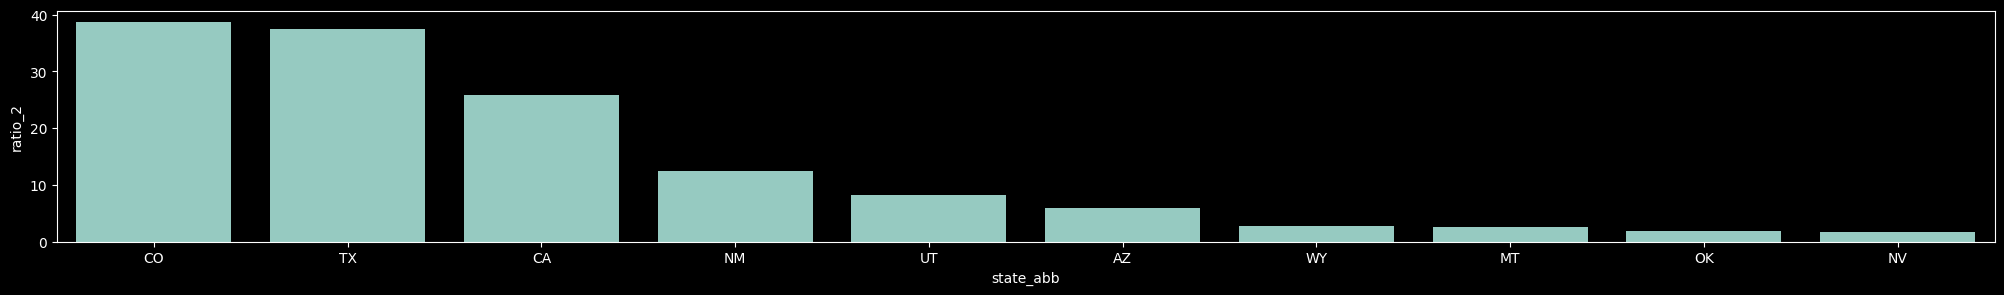

In [48]:
# 가뭄지역 Top10 중 물저장 비율이 가장 적은 CO, TX, CA, ..., NV 순으로 가뭄 복구 시작
sns.barplot(x="state_abb", y='ratio_2', data=df_merge);
plt.gcf().set_size_inches(25, 3)